# DU-GD法 (リッジ回帰問題)

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

### 準備 (グローバル定数の設定)

In [2]:
n = 50　
m = 100　
num_itr = 50
K = 100
λ = 3.0
adam_lr1 = 1e-4
adam_lr2 = 1e-2
max_inner = 50

A = randn(m,n)
Pinv = (A'*A + λ*I)^(-1)*A'
eig = eigvals(A'*A + λ*I)
λmin = minimum(eig)
λmax = maximum(eig)
ηopt = 2/(λmin + λmax)

0.006299085814089458

### ミニバッチ生成関数

In [3]:
function mini_batch(K)
    y = randn(m,K)
    x_opt = Pinv*y
    return y, x_opt
end

mini_batch (generic function with 1 method)

### 固定ステップサイズのGD法のMSE

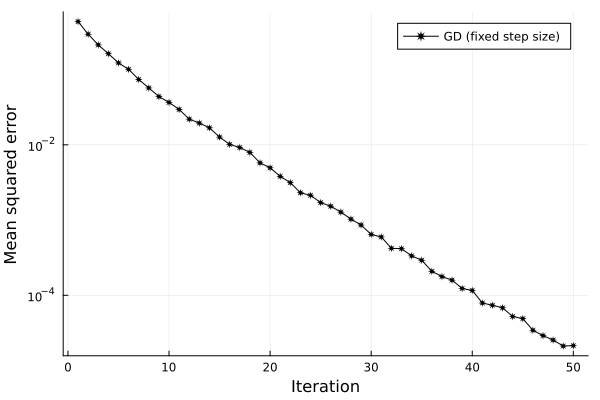

In [4]:
function GD(max_itr, y)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - ηopt*(A'*(A*x - y) + λ*x)
    end
    return return x
end

function comp_mse(max_itr)
    y, x_opt = mini_batch(K)
    x̂ = GD(max_itr, y)
    return norm(x_opt - x̂)^2/K
end
        
GD_mse = [comp_mse(i) for i in 1:num_itr]
plot(1:num_itr, GD_mse, lw=1, yscale=:log10, label="GD (fixed step size)", marker=:star8, color=:black, xlabel="Iteration", ylabel="Mean squared error")

### DU-GD反復の定義 

In [5]:
function DU_GD(max_itr, y, η, ξ, enable_ξ)
    x = zeros(n, K)
    for i in 0:max_itr-1
        k = (i % T)+1
        if enable_ξ == true 
            x = x - η[k]*(A'*(A*x -y) + abs.(ξ[i+1])*x)
        else 
            x = x - η[k]*(A'*(A*x -y) + λ*x)
        end
    end
    return x
end

DU_GD (generic function with 1 method)

### 損失関数の定義

In [6]:
function loss(x_opt, x̂)
    return norm(x_opt - x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [7]:
function train(η, ξ, enable_ξ)
    ps1 = Flux.params(η) 
    ps2 = Flux.params(ξ) 
    opt1 = Flux.ADAM(adam_lr1)
    opt2 = Flux.ADAM(adam_lr2)
    
    for itr in 1:num_itr # outer loop
        for i in 1:max_inner # inner loop
            y, x_opt = mini_batch(K)
            gs = Flux.gradient(()->loss(x_opt, DU_GD(itr, y, η, ξ, enable_ξ)), ps1) 
            Flux.Optimise.update!(opt1, ps1, gs) 
            gs = Flux.gradient(()->loss(x_opt, DU_GD(itr, y, η, ξ, enable_ξ)), ps2) 
            Flux.Optimise.update!(opt2, ps2, gs) 

        end
        # check for temporal MSE
        y, x_opt = mini_batch(K)
        x̂ = DU_GD(itr, y, η, ξ, enable_ξ)
        println(itr, " ", loss(x_opt, x̂))
    end
end

train (generic function with 1 method)

### DU-GDのMSE評価用関数

In [8]:
function comp_mse_DUGD(max_itr, η, ξ, enable_ξ)
    y, x_opt = mini_batch(K)
    x̂ = DU_GD(max_itr, y, η, ξ, enable_ξ)
    return loss(x_opt, x̂)
end

comp_mse_DUGD (generic function with 1 method)

### $\xi^{(t)} = \lambda$と固定、ステップサイズは学習する

1 0.5052518217419268
2 0.2896000931057397
3 0.17458498555394059
4 0.11205792930239752
5 0.06903992637112565
6 0.04316066931773555
7 0.033637485629028574
8 0.021181883209882773
9 0.012589711083233836
10 0.0070632718170234934
11 0.004763006218701736
12 0.004258511685560024
13 0.002638736024587215
14 0.0015256481827880342
15 0.0016577452279151886
16 0.0011992342413878639
17 0.0008466534084431369
18 0.0004587519898081624
19 0.0004084955168101181
20 0.00031268199876114034
21 0.0002133059789077222
22 0.00011940770344643243
23 0.00010334049267510472
24 8.036673906001688e-5
25 5.59835999181174e-5
26 3.426024229351147e-5
27 2.909063222440321e-5
28 2.033607346063302e-5
29 1.959976863145511e-5
30 9.45840613192758e-6
31 8.666119483884981e-6
32 7.4576221818049535e-6
33 4.500521532564737e-6
34 3.0118553818548457e-6
35 2.5899121041200566e-6
36 2.3236904142036924e-6
37 1.5514622920155847e-6
38 9.067238014508046e-7
39 8.448667082133284e-7
40 6.165519955954033e-7
41 4.2335090423118614e-7
42 2.9413085078

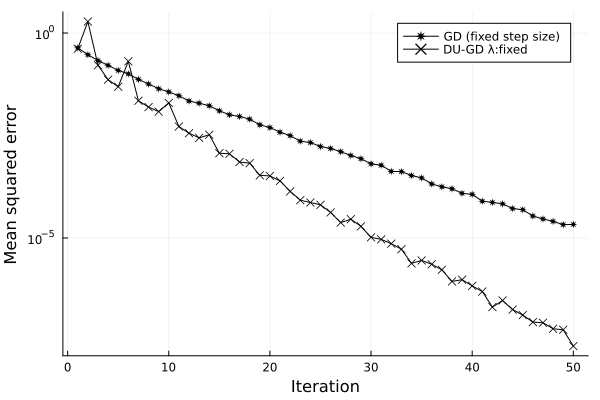

In [9]:
T = 4
enable_ξ = false
η_train = zeros(num_itr) 
ξ_train = λ*ones(num_itr) 
train(η_train, ξ_train, enable_ξ)
DUGD_mse =[comp_mse_DUGD(i, η_train, ξ_train, enable_ξ) for i in 1:num_itr]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD λ:fixed", color=:black, marker=:x)

### 学習過程 $\xi^{(t)}$を学習

In [10]:
enable_ξ = true
η_train = zeros(num_itr) 
ξ_train = λ*ones(num_itr) 
train(η_train, ξ_train, enable_ξ)
ξ_train

1 0.4936124318812369
2 0.2782529508488635
3 0.17195734996582096
4 0.12225784554642749
5 0.06429700550232544
6 0.03554698316107494
7 0.022559347647153803
8 0.013558240701263533
9 0.008629040111868672
10 0.0037412649447869663
11 0.00228248203505238
12 0.0017967735929577116
13 0.0010850343055353398
14 0.0004605705068386753
15 0.00040182148625528616
16 0.0002769006702699066
17 0.00015192952333013842
18 7.062385084142908e-5
19 5.536044581438611e-5
20 5.0367882275869375e-5
21 2.8887940719262524e-5
22 1.126018291632124e-5
23 1.0370465606646084e-5
24 8.533052985156182e-6
25 5.046457347330408e-6
26 2.299088050581342e-6
27 2.0582595096661857e-6
28 1.726551327777674e-6
29 8.996702376794001e-7
30 4.800307509024787e-7
31 4.114491572211088e-7
32 3.354370291362541e-7
33 2.259803779782497e-7
34 1.1607312983552734e-7
35 8.303385702019637e-8
36 8.264951281935923e-8
37 5.72636942412402e-8
38 2.503798084061073e-8
39 2.345069023443481e-8
40 1.5342117225598395e-8
41 1.4133559407168039e-8
42 6.54977062240479

50-element Vector{Float64}:
  3.0
 -2.29991915192644e-9
  0.21623283774405916
  0.027130953354942037
 -3.4339472200759217e-9
  1.1688719913437209e-9
  4.209364655428321e-8
  4.226348824515875e-8
 -5.3951488547418065e-8
  0.45116416333585685
  8.208623741390424e-7
  0.6452384685852833
  1.1982659703278056
  ⋮
  3.009490463365038
  3.0008760682439513
  3.0046436800846394
  3.0016603588605584
  3.004912134890349
  3.00072642697363
  2.999754823998207
  3.000089231798571
  2.996346498255215
  2.9994304922345396
  2.9998555581124497
  2.998539264042081

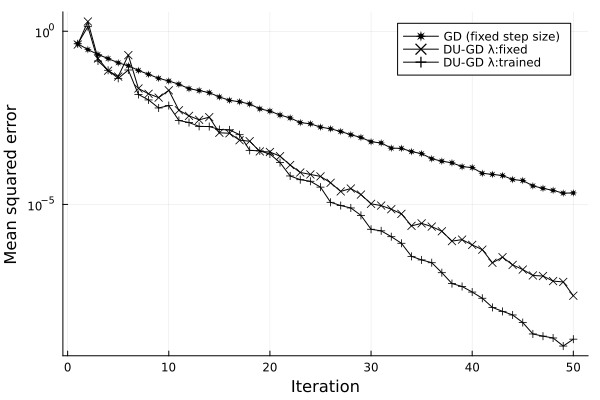

In [11]:
DUGD_mse =[comp_mse_DUGD(i, η_train, ξ_train, enable_ξ) for i in 1:num_itr]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD λ:trained", color=:black, marker=:+)

In [12]:
savefig("DU-GD-Ridge.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_3/DU-GD-Ridge.pdf"

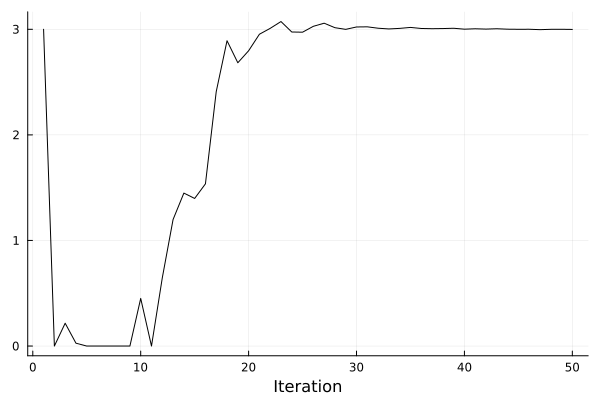

In [13]:
plot(1:num_itr, abs.(ξ_train), xlabel="Iteration", color=:black, legend=false)

In [14]:
savefig("DU-GD-Ridge-param.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_3/DU-GD-Ridge-param.pdf"